In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/200kstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 344 µs, sys: 265 µs, total: 609 µs
Wall time: 1.06 ms


In [11]:
N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.325735]
r_big = [0.325735,0.46065886]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,5.395644,0.178844,-5.216800
1,0.602763,0.544883,2,1,0.507081,-4.717533,5.224614
2,0.423655,0.645894,2,0,0.830343,-5.520674,-6.351017
3,0.437587,0.891773,1,1,2.434823,3.745080,-1.310257
4,0.963663,0.383442,0,0,5.668825,0.959905,-4.708920


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.499785,0.499334,0.998640,0.501805,0.829071,0.840375,1.013689
std,0.288533,0.289177,0.815452,0.499998,5.053237,5.040885,7.095153
min,0.000003,0.000003,0.000000,0.000000,-24.011493,-23.477268,-29.975152
25%,0.249671,0.247699,0.000000,0.000000,-2.568341,-2.573902,-3.754748
50%,0.501024,0.498865,1.000000,1.000000,0.851500,0.835961,1.002317
75%,0.749132,0.750450,2.000000,1.000000,4.240763,4.251074,5.781476
max,0.999990,0.999999,2.000000,1.000000,24.583311,22.920856,33.582026


In [14]:
data['C'].value_counts()/len(data)

1    0.33504
0    0.33316
2    0.33180
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0    0.046584
1    0.990256
2    2.008421
Name: ITE, dtype: float64

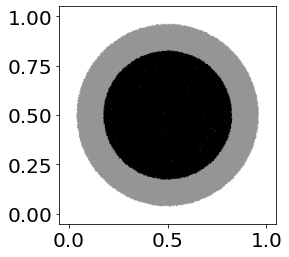

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 5min 13s, sys: 239 ms, total: 5min 13s
Wall time: 5min 13s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,2,0,5.395644,0.178844,-5.216800,0,2.564066,-2.831578
1,0.602763,0.544883,2,1,0.507081,-4.717533,5.224614,0,-1.902026,2.409107
2,0.423655,0.645894,2,0,0.830343,-5.520674,-6.351017,0,1.730433,0.900090
3,0.437587,0.891773,1,1,2.434823,3.745080,-1.310257,0,1.281547,1.153276
4,0.963663,0.383442,0,0,5.668825,0.959905,-4.708920,0,-0.729681,-6.398505


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        0.975056  1.031739  1.001298  0.056684  0.026242
            1        0.979071  1.090171  0.953157  0.111100 -0.025914
          1 0        0.023693  0.963958  1.073699  0.940265  1.050006
            1       -0.058885  1.012906  1.075901  1.071791  1.134786
          2 0       -0.019793  2.027167  1.906816  2.046960  1.926609
            1       -0.013576  2.059293  1.911627  2.072870  1.925203
1         0 0        1.012942  0.983916  0.935166  0.029026  0.077776
            1        1.046034  1.033541  0.887341  0.012494  0.158694
          1 0        1.024083  0.013366  0.075004  1.010716  0.949079
            1        1.013904 -0.012539  0.061434  1.026443  0.952471
          2 0        1.958650  0.005046 -0.029671  1.953603  1.988321
            1        1.996272 -0.014594 -0.010269  2.010866  2.006541

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 1h 57min 59s, sys: 20.6 s, total: 1h 58min 20s
Wall time: 3min 8s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,5.395644,0.178844,-5.216800,0,2.564066,-2.831578,326,418
1,0.602763,0.544883,2,1,0.507081,-4.717533,5.224614,0,-1.902026,2.409107,243,384
2,0.423655,0.645894,2,0,0.830343,-5.520674,-6.351017,0,1.730433,0.900090,281,430
3,0.437587,0.891773,1,1,2.434823,3.745080,-1.310257,0,1.281547,1.153276,387,61
4,0.963663,0.383442,0,0,5.668825,0.959905,-4.708920,0,-0.729681,-6.398505,188,437


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.253510,491.0,1.0,0.002455
1,1,-0.222059,450.0,1.0,0.002250
2,2,0.233919,450.0,1.0,0.002250


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


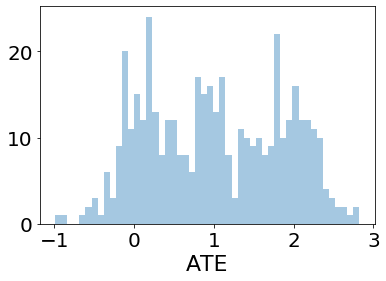

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 50
fig, ax = plt.subplots(1,1)
#ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax = sns.distplot(box['Box-ATT'].values, bins=bins, kde = False,ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


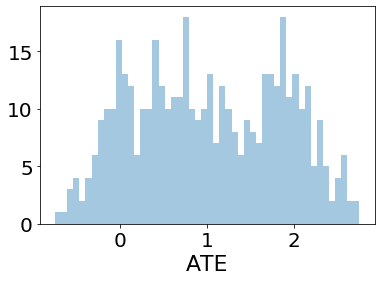

In [26]:
fig, ax = plt.subplots(1,1)
#ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
#                 bins = bins, kde = kde, ax = ax)

ax = sns.distplot(kmeans['Kmeans-ATT'],
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


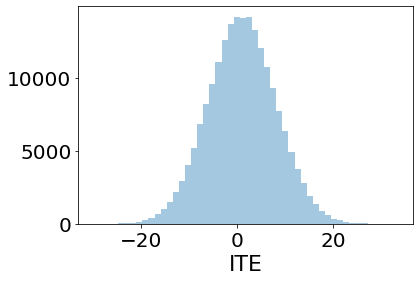

In [27]:
fig, ax = plt.subplots(1,1)
#ax = sns.distplot(data['ITE'], bins = bins,hist_kws={'weights': np.ones(len(data))/len(data)},
#                  kde = kde, ax = ax)
ax = sns.distplot(data['ITE'], bins = bins,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,441.00000,441.000000,441.000000,441.000000,441.000000
mean,220.00000,1.014447,453.514739,0.953015,0.002268
std,127.44999,0.845440,21.551110,0.094993,0.000108
min,0.00000,-0.993121,399.000000,0.627232,0.001995
25%,110.00000,0.233919,439.000000,0.965293,0.002195
50%,220.00000,0.973268,453.000000,1.000000,0.002265
75%,330.00000,1.788780,468.000000,1.000000,0.002340
max,440.00000,2.824453,520.000000,1.000000,0.002600


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


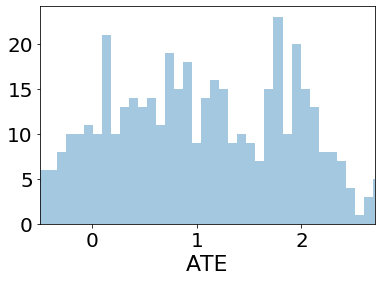

In [30]:
fig, ax = plt.subplots(1,1)
#ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax = sns.distplot(box2['Box-ATT'], bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
ax.set_xlim(-0.5,2.7)

if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


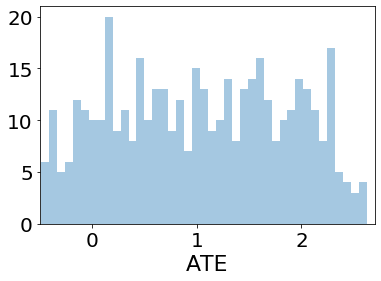

In [31]:
fig, ax = plt.subplots(1,1)
#ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
#             bins = bins, kde = kde, ax = ax)
ax = sns.distplot(kmeans2['Kmeans-ATT'],
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
ax.set_xlim(-0.5,2.7)
if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


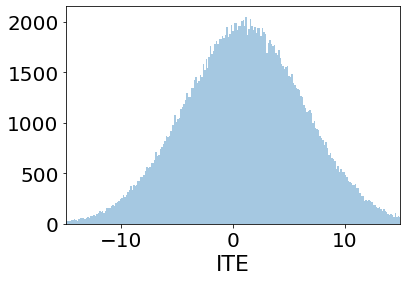

In [32]:
fig, ax = plt.subplots(1,1)
bins = 400
#ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax, hist_kws={'weights': np.ones(len(data))/len(data)})
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 3
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N )
    


CPU times: user 889 ms, sys: 59 ms, total: 948 ms
Wall time: 1.24 s


In [34]:
box['Box-Cl2'].value_counts()

0    154
2    147
1    140
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.253510,491.0,1.0,0.002455,0
1,1,-0.222059,450.0,1.0,0.002250,0


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,5.395644,0.178844,-5.216800,0,2.564066,-2.831578,326,418
1,0.602763,0.544883,2,1,0.507081,-4.717533,5.224614,0,-1.902026,2.409107,243,384


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5

data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2

#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,2,0,5.395644,0.178844,-5.216800,0,2.564066,-2.831578,326,418,0,0,2,2,2,1
1,0.602763,0.544883,2,1,0.507081,-4.717533,5.224614,0,-1.902026,2.409107,243,384,2,2,2,2,2,2


### Plot reconstruction of data

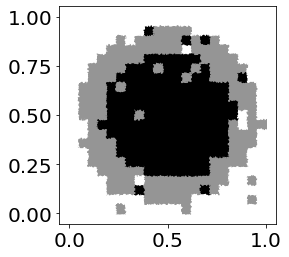

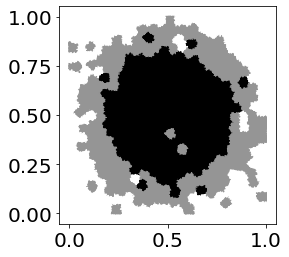

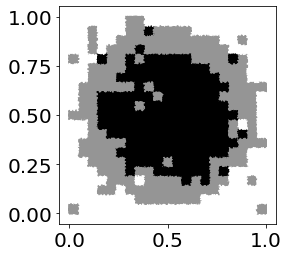

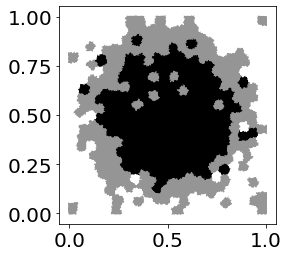

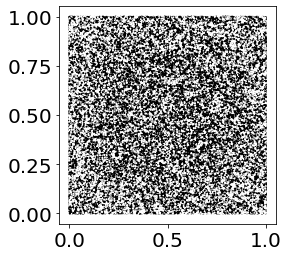

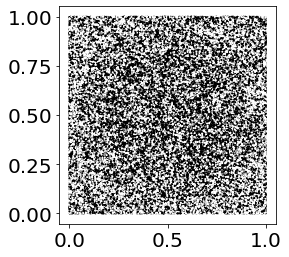

CPU times: user 58 s, sys: 1.53 s, total: 59.6 s
Wall time: 58 s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Box-Cl2-err-True-ITE,0.139866,0.304407
Box-Cl2-err-GDBR,0.161241,0.289833
Box2-Cl2-err-GDBR,0.167912,0.352706
Kmeans-Cl2-err-True-ITE,0.175821,0.323485
Box2-Cl2-err-True-ITE,0.191073,0.334068
Kmeans-Cl2-err-GDBR,0.191481,0.311228
Kmeans2-Cl2-err-GDBR,0.207259,0.374389
Kmeans2-Cl2-err-True-ITE,0.237714,0.345197
ITE-2CTrue-err-GDBR,2.822368,0.952376
ITE-2CGDBR-err-True-ITE,3.727945,1.169458


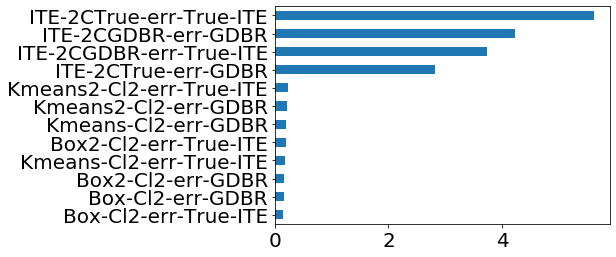

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 3, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.934551,0.065074,0.000375
C1 True,0.112852,0.803591,0.083557
C2 True,0.000211,0.083183,0.916606


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.843829,0.156171,0.000000
C1 True,0.114210,0.774803,0.110987
C2 True,0.000000,0.047559,0.952441


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.852878,0.145906,0.001216
C1 True,0.078856,0.799442,0.121702
C2 True,0.000000,0.109916,0.890084


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.820537,0.177797,0.001666
C1 True,0.148729,0.709617,0.141655
C2 True,0.000000,0.091606,0.908394


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.527359,0.056219,0.416422
C1 True,0.472436,0.055665,0.471899
C2 True,0.416079,0.055335,0.528586


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.535283,0.072713,0.392004
C1 True,0.461214,0.076274,0.462512
C2 True,0.388547,0.074277,0.537176


In [49]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.500013,0.499027,0.892990,0.499740,0.822047,0.856666,-3.066394,0.198937,0.841729,-3.622296,219.553738,218.950106,0.500422,0.877247,0.929945,0.919670,0.917786,0.162841,0.194173,0.167371,0.207467,2.823058,4.515286,0.143350,0.180451,0.191425,0.240438,5.606672,3.959384
1,0.499150,0.498537,1.005643,0.505946,0.827248,0.857755,0.931507,0.204098,0.816755,0.997093,219.324421,219.523883,0.988512,0.987437,1.044541,1.028888,1.032113,0.163411,0.193091,0.170364,0.211133,2.849688,0.657649,0.142114,0.177873,0.193012,0.241130,5.584804,0.680539
2,0.499660,0.499768,1.102707,0.503196,0.836357,0.821365,5.089234,0.200401,0.804145,5.615891,219.905325,220.766147,1.499660,1.087614,1.135502,1.131286,1.133238,0.159300,0.188542,0.168058,0.206431,2.817297,4.513184,0.136037,0.170881,0.190411,0.234454,5.610642,3.986527


In [50]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(4.246035196685484, 3.227185517871584)